# NDP Song Lyric Generation (using RNN LSTM)

_Inspired by [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation)_

In [82]:
# codes to mount your google drive folder
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/Othercomputers/My Computer (1)/CS605_NLP_for_Smart_Assistants/Project/NLP-Lyric-Generator/src/bin

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Othercomputers/My Computer (1)/CS605_NLP_for_Smart_Assistants/Project/NLP-Lyric-Generator/src/bin


## Import dependencies

In [192]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os
import re
import sys

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# from nltk.corpus import stopwords
from wordcloud import WordCloud
from PIL import Image
from sklearn.model_selection import train_test_split
from gensim import downloader

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.13
Tensorflow version: 2.8.2
Keras version: 2.8.0


In [3]:
### Custom Imports
sys.path.append('../')
import lib.utilities as utils
from lib.sentiment import Sentiment

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Download the dataset

In [4]:
PATH = '../../data'

In [5]:
dataset_file_names = os.listdir(PATH)
dataset_file_names[:5]

['Because it_s Singapore.txt',
 'City for the World.txt',
 'Everybody Is Special.txt',
 'Count On Me Singapore.txt',
 'Everything I Am.txt']

In [6]:
corpus = ''
for i,file in enumerate(dataset_file_names):
    text = open(PATH + '/' + file, mode='r').read()
    if i == 0:
        corpus += text
    else:
        corpus = corpus + '\n\n' + text

## Analyze the dataset

In [7]:
print('Length of Corpus: {} characters'.format(len(corpus)))

Length of Corpus: 56772 characters


In [8]:
# Take a look at the first 1000 characters in text.
print(corpus[:1000])

<VERSE>
Step by step Together we'll build our dreams
Heart to heart Together we'll stay as one nation, undivided 
Back to back Together we'll brave the heat, the cold, the storms
Hand in hand Together we'll grow this land that we call home

<CHORUS>
Nothing in this world compares
It's our Singaporean Life
Everyone is family, friend and neighbour
Living in harmony
Nothing in this world compares
To this island where it's home
Where we love and know
we'll never be alone
Because it's Singapore

<VERSE>
Step by step Together we'll build our dreams
Heart to heart Together we'll stay as one nation, undivided
Back to back Together we'll brave the heat, the cold, the storms
Hand in hand Together we'll grow this land that we call home

<CHORUS>
Nothing in this world compares
It's our Singaporean Life
Everyone is family, friend and neighbour
Living in harmony
Nothing in this world compares
To this island where it's home
Where we love and know
we'll never be alone

<CHORUS>
Nothing in this world c

In [9]:
# clean corpus
corpus_clean = utils.decontraction(corpus)
corpus_clean = utils.remove_punct(corpus_clean, '\<|\>')

# tokenize and count the number of words
corpus_clean = re.sub('\n\n', '\n', corpus_clean)
corpus_clean = re.sub('\n', ' \n ', corpus_clean)
tokens = re.split(' ', corpus_clean)
tokens_clean = []
structures = ['<BRIDGE>', '<CHORUS>', '<OTHERS>', '<PRECHORUS>', '<PRELUDE>', '<VERSE>']
for i,t in enumerate(tokens):
    if t:                                  # remove empty strings
        if i < len(tokens)-1 and t == '\n' and tokens[i+1] in structures:
            tokens_clean.append('\n\n')    # change to double line break for token before structure 
        elif t not in structures:
            tokens_clean.append(t.lower()) # lower case if not structure tokens
        else:
            tokens_clean.append(t)
    
print('Length of Corpus: {} words'.format(len(tokens_clean)))

# The unique words in the file
vocab = sorted(set(tokens_clean))
print('Vocab Size:', len(vocab))
print('Vocab Examples:', tokens_clean[:20])

Length of Corpus: 13483 words
Vocab Size: 1042
Vocab Examples: ['<VERSE>', '\n', 'step', 'by', 'step', 'together', 'we', 'will', 'build', 'our', 'dreams', '\n', 'heart', 'to', 'heart', 'together', 'we', 'will', 'stay', 'as']


In [10]:
print(tokens_clean[:100])

['<VERSE>', '\n', 'step', 'by', 'step', 'together', 'we', 'will', 'build', 'our', 'dreams', '\n', 'heart', 'to', 'heart', 'together', 'we', 'will', 'stay', 'as', 'one', 'nation', 'undivided', '\n', 'back', 'to', 'back', 'together', 'we', 'will', 'brave', 'the', 'heat', 'the', 'cold', 'the', 'storms', '\n', 'hand', 'in', 'hand', 'together', 'we', 'will', 'grow', 'this', 'land', 'that', 'we', 'call', 'home', '\n\n', '<CHORUS>', '\n', 'nothing', 'in', 'this', 'world', 'compares', '\n', 'it', 'is', 'our', 'singaporean', 'life', '\n', 'everyone', 'is', 'family', 'friend', 'and', 'neighbour', '\n', 'living', 'in', 'harmony', '\n', 'nothing', 'in', 'this', 'world', 'compares', '\n', 'to', 'this', 'island', 'where', 'it', 'is', 'home', '\n', 'where', 'we', 'love', 'and', 'know', '\n', 'we', 'will', 'never']


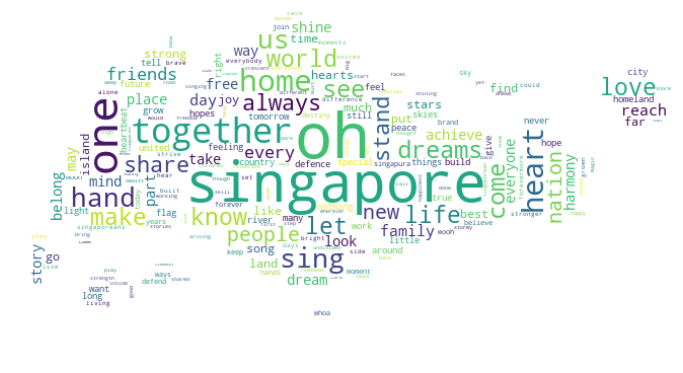

In [11]:
# Unigram Word Cloud

# remove stopwords
stop = set(stopwords.words('english'))
stop.update(structures)
stop.update(['\n', '\n\n'])
tokens_no_stopwords = [t for t in tokens_clean if t not in stop]

corpus_dict = {}
for word in tokens_no_stopwords:
    corpus_dict[word] = corpus_dict.get(word, 0) + 1

sg_mask = np.array(Image.open("../../images/singaporemap.png"))
my_cloud = WordCloud(background_color='white', stopwords=stop, mask=sg_mask).generate_from_frequencies(corpus_dict)

plt.figure(figsize=(12,10))
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis('off')
plt.show()

## Process the dataset

### Vectorize the text

Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [12]:
# get word and indices mapping
word_indices = {}
indices_word = {}
for i, w in enumerate(sorted(set(tokens_clean))):
    word_indices[w] = i
    indices_word[i] = w

In [13]:
# convert data to indices numbers (vectorize):
tokens_clean = np.array(tokens_clean)
tokens_clean_idx = np.vectorize(word_indices.get)(tokens_clean)

### Create sequences

In [128]:
word_dataset = tf.data.Dataset.from_tensor_slices(tokens_clean_idx)

In [129]:
SEQUENCE_LEN = 15
sequences = word_dataset.window(SEQUENCE_LEN + 1, 1, drop_remainder=True)

for window in sequences.take(3):
    print(repr(' '.join(np.vectorize(indices_word.get)(np.array(list(window.as_numpy_iterator()))))))

'<VERSE> \n step by step together we will build our dreams \n heart to heart together'
'\n step by step together we will build our dreams \n heart to heart together we'
'step by step together we will build our dreams \n heart to heart together we will'


In [130]:
sequences = sequences.flat_map(lambda window: window.batch(SEQUENCE_LEN + 1))
for elem in sequences.take(3):
    print(elem)


tf.Tensor([  7   0 810 129 810 894 973 997 121 605 253   0 400 892 400 894], shape=(16,), dtype=int64)
tf.Tensor([  0 810 129 810 894 973 997 121 605 253   0 400 892 400 894 973], shape=(16,), dtype=int64)
tf.Tensor([810 129 810 894 973 997 121 605 253   0 400 892 400 894 973 997], shape=(16,), dtype=int64)


In [131]:
sequences = sequences.map(lambda window: (window[:-1], window[-1:]))
X_train = sequences.map(lambda X,y: X)
y_train = sequences.map(lambda X,y: y)

for elem1, elem2 in zip(X_train.take(3), y_train.take(3)):
    print(elem1, '----->', elem2)

tf.Tensor([  7   0 810 129 810 894 973 997 121 605 253   0 400 892 400], shape=(15,), dtype=int64) -----> tf.Tensor([894], shape=(1,), dtype=int64)
tf.Tensor([  0 810 129 810 894 973 997 121 605 253   0 400 892 400 894], shape=(15,), dtype=int64) -----> tf.Tensor([973], shape=(1,), dtype=int64)
tf.Tensor([810 129 810 894 973 997 121 605 253   0 400 892 400 894 973], shape=(15,), dtype=int64) -----> tf.Tensor([997], shape=(1,), dtype=int64)


In [132]:
dataset_size = len(list(sequences.as_numpy_iterator()))
print('dataset size: {}'.format(dataset_size))

dataset size: 13468


In [133]:
val_size = int(0.2 * dataset_size)
val_dataset = sequences.take(val_size) 
train_dataset = sequences.skip(val_size)

In [134]:
BATCH_SIZE = 128

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000

AUTOTUNE = tf.data.AUTOTUNE
# dataset = sequences.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)

print('Batched dataset size: {}'.format(len(list(train_dataset.as_numpy_iterator()))))

Batched dataset size: 84


### Build and Test Model

In [170]:
VOCAB_SIZE = len(vocab)
EMBEDDINGG_DIM = 128
RNN_UNITS = 512

EPOCHS=10
LR = 0.001

In [171]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    """Build Keras Model

    Args: 
      vocab_size (int): size of vocabulary of corpus
      embedding_dim (int): dimension of word embedding matrix
      rnn_units (int): number of neurons in rnn
      batch_size (int): batch size 

    
    Returns:
      Keras sequential model 
    """
    
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=False,
#       stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.LayerNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(vocab_size))
  
    return model


model = build_model(VOCAB_SIZE, EMBEDDINGG_DIM, RNN_UNITS, BATCH_SIZE)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (128, None, 128)          133376    
                                                                 
 lstm_12 (LSTM)              (128, 512)                1312768   
                                                                 
 layer_normalization_1 (Laye  (128, 512)               1024      
 rNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (128, 512)                0         
                                                                 
 dense_12 (Dense)            (128, 1042)               534546    
                                                                 
Total params: 1,981,714
Trainable params: 1,981,714
Non-trainable params: 0
___________________________________________

In [172]:
for input_example_batch, target_example_batch in train_dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(128, 1042) # (batch_size, sequence_length, vocab_size)


In [173]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    """Compute the loss from outputed logits of model

    Args: 
      labels (list): y labels / ground truth
      logits (list): logits outputed by the model
    
    Returns:
      Loss score
    """
    
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (128, 1042)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       6.9389567


In [174]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

In [175]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

### Train Model

In [176]:
history = model.fit(
  x=train_dataset,
  epochs=EPOCHS,
  validation_data=val_dataset,
  shuffle=True,
  callbacks=[
    checkpoint_callback
  ]
)

Epoch 1/10
84/84 [==============================] - 3s 16ms/step - loss: 4.9398 - val_loss: 4.6899
Epoch 2/10
84/84 [==============================] - 1s 11ms/step - loss: 3.6974 - val_loss: 4.5622
Epoch 3/10
84/84 [==============================] - 1s 12ms/step - loss: 2.7760 - val_loss: 4.7216
Epoch 4/10
84/84 [==============================] - 1s 10ms/step - loss: 2.0795 - val_loss: 5.0017
Epoch 5/10
84/84 [==============================] - 1s 10ms/step - loss: 1.5579 - val_loss: 5.3375
Epoch 6/10
84/84 [==============================] - 1s 12ms/step - loss: 1.1588 - val_loss: 5.6957
Epoch 7/10
84/84 [==============================] - 1s 10ms/step - loss: 0.8597 - val_loss: 6.0251
Epoch 8/10
84/84 [==============================] - 1s 10ms/step - loss: 0.6564 - val_loss: 6.2901
Epoch 9/10
84/84 [==============================] - 1s 14ms/step - loss: 0.5194 - val_loss: 6.5507
Epoch 10/10
84/84 [==============================] - 1s 10ms/step - loss: 0.4040 - val_loss: 6.7772


### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different `batch_size`, we need to rebuild the model and restore the weights from the checkpoint.

In [177]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints/ckpt_10'

In [178]:
simplified_batch_size = 1

model = build_model(VOCAB_SIZE, EMBEDDINGG_DIM, RNN_UNITS, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([simplified_batch_size, None]))

In [179]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (1, None, 128)            133376    
                                                                 
 lstm_13 (LSTM)              (1, 512)                  1312768   
                                                                 
 layer_normalization_2 (Laye  (1, 512)                 1024      
 rNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (1, 512)                  0         
                                                                 
 dense_13 (Dense)            (1, 1042)                 534546    
                                                                 
Total params: 1,981,714
Trainable params: 1,981,714
Non-trainable params: 0
___________________________________________

### The prediction loop

The following code block generates the text:

- It Starts by choosing a start string, initializing the RNN state and setting the number of words to generate.

- Get the prediction distribution of the next word using the start string and the RNN state.

- Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted word as our next input to the model.

- The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one word. After predicting the next word, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted words.

In [180]:
# num_generate
# - number of words to generate.
#
# temperature

# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    """Generate text using trained sequential text generation model

    Args: 
      model (model): Keras trained sequential text generation model
      start_string (list): list of strings for starting the text generation
      num_generate (int): number of words to generate
      temperature (float): controls the predictability of the generated text
        - Low temperatures results in more predictable text.
        - Higher temperatures results in more surprising text.
    
    Returns:
      String of generated text
      
    """

    # Converting our start string to numbers (vectorizing).
    input_indices = [word_indices[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for word_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predictions = tf.reshape(predictions, [1, predictions.shape[0]])
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
            )[-1,0].numpy()

        # We pass the predicted word as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(indices_word[predicted_id])
    
    return (' '.join(start_string) + ' ' + ' '.join(text_generated))

In [181]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=['<CHORUS>', '\n'], num_generate=30))

<CHORUS> 
 this is needs your history you are my heart 
 into the way 
 stars 
 we have to go with all of part for singapore 
 till i have


In [182]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=['<CHORUS>', '\n'], num_generate=30))

<CHORUS> 
 our danced in the same the best to hours 
 maybe 
 nothing 
 songs of us sunrise on the great uneventfullest 
 though the great on the same 




In [183]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=['<VERSE>', '\n'], num_generate=30))

<VERSE> 
 in the skys the sky 
 no matter a brand new world 

 <CHORUS> 
 then could in my heart and started 
 maybe 
 there is the times 



In [184]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=['<VERSE>', '\n'], num_generate=30))

<VERSE> 
 surprises 
 strangers i have days 
 what we are so far 
 both strong and enemies 
 fly 
 no matter where we are my home 
 no place


str

In [187]:
# Generate the text with higher temperature to get more unexpected results.

text = ''
text += generate_text(model, start_string=['<CHORUS>', '\n'], num_generate=30, temperature=1.5)
text += generate_text(model, start_string=['<CHORUS>', '\n'], num_generate=30, temperature=1.5)
text += generate_text(model, start_string=['<VERSE>', '\n'], num_generate=30, temperature=1.5)
text += generate_text(model, start_string=['<VERSE>', '\n'], num_generate=30, temperature=1.5)

print(text)

<CHORUS> 
 that side at home 
 what must the future lead i want to stay 
 youll since we will go <PRECHORUS> 
 singaporeans 
 no matter 
 the thames made<CHORUS> 
 clean and now we can every tourists recognise you can forget day 
 no matter a brand brings feeling changed 
 together 
 to see 

 <VERSE> 
 it is<VERSE> 
 it is a brave hundred leaving each river 
 nothing feel the best that nothings slowly real 
 show i believe 
 downstairs to keep my friends 
 recognise how<VERSE> 
 we miss to help defend and nation lend like me 

 <CHORUS> 
 though the song 
 within 

 <CHORUS> 
 life you have 
 where moved you carried the


### Evaluate sentiment of generated text

In [188]:
generated_text = re.sub(r'<[A-Z]+>|', '', text)
generated_text = re.sub(r'\n', ' ', generated_text)
generated_text = re.sub('\s+', ' ', generated_text)
generated_text = generated_text.strip()

generated_text

'that side at home what must the future lead i want to stay youll since we will go singaporeans no matter the thames made clean and now we can every tourists recognise you can forget day no matter a brand brings feeling changed together to see it is it is a brave hundred leaving each river nothing feel the best that nothings slowly real show i believe downstairs to keep my friends recognise how we miss to help defend and nation lend like me though the song within life you have where moved you carried the'

In [191]:
clean_corpus = re.sub(r'<[A-Z]+>|', '', corpus_clean)
clean_corpus = re.sub(r'\n', ' ', clean_corpus)
clean_corpus = re.sub('\s+', ' ', clean_corpus)
clean_corpus = clean_corpus.strip()

clean_corpus[:500]

'Step by step Together we will build our dreams Heart to heart Together we will stay as one nation undivided Back to back Together we will brave the heat the cold the storms Hand in hand Together we will grow this land that we call home Nothing in this world compares It is our Singaporean Life Everyone is family friend and neighbour Living in harmony Nothing in this world compares To this island where it is home Where we love and know we will never be alone Because it is Singapore Step by step To'

In [193]:
print(list(downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [194]:
glove_vectors = downloader.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [198]:
# create Sentiment object
sentiment = Sentiment()

# clean and tokenize text
sentiment.clean_text(
    original_text = clean_corpus, 
    generated_text = generated_text, 
    remove_stopwords=True, 
    stop_words = set(stopwords.words("english"))
)

print(sentiment.original_tokens[:10])
print(sentiment.generated_tokens)

['step', 'step', 'together', 'build', 'dreams', 'heart', 'heart', 'together', 'stay', 'one']
['side', 'home', 'must', 'future', 'lead', 'want', 'stay', 'youll', 'since', 'go', 'singaporeans', 'matter', 'thames', 'made', 'clean', 'every', 'tourists', 'recognise', 'forget', 'day', 'matter', 'brand', 'brings', 'feeling', 'changed', 'together', 'see', 'brave', 'hundred', 'leaving', 'river', 'nothing', 'feel', 'best', 'nothings', 'slowly', 'real', 'show', 'believe', 'downstairs', 'keep', 'friends', 'recognise', 'miss', 'help', 'defend', 'nation', 'lend', 'like', 'though', 'song', 'within', 'life', 'moved', 'carried']


In [202]:
# this step scores the vader sentiment of the original and generated text 
sentiment.score_vader_sentiment()  
print(sentiment.vader_sentiment_scores)

{'original': {'neg': 0.015, 'neu': 0.613, 'pos': 0.372, 'compound': 1.0}, 'generated': {'neg': 0.099, 'neu': 0.621, 'pos': 0.28, 'compound': 0.8602}}


In [203]:
# this step extracts the top n similar word vectors to each theme
# and get their average word vector
sentiment.get_theme_vector(
    sentiment_themes=['patriot', 'love'], 
    embedding=glove_vectors, 
    topn=10
)
print(sentiment.sentiment_themes)
print(sentiment.all_theme_vectors)

['patriot', 'love']
{'patriot': array([-0.0932492 ,  0.2737941 ,  0.46496803, -0.1104055 , -0.4727427 ,
       -0.3695609 ,  0.59728706, -0.56995434, -0.49318305,  1.152441  ,
        0.20548022, -0.665005  , -0.35317498, -0.05724651,  0.29801202,
       -0.1887181 ,  0.46808147,  0.29274267, -0.3542009 , -0.390468  ,
        0.41724506, -0.3645263 , -0.02154259,  0.15602511,  0.3117882 ,
        0.2808048 , -0.40197968,  0.19433399, -0.207225  ,  0.41112152,
       -0.40770826,  0.41357788, -0.06724178,  0.2552355 ,  0.6959089 ,
       -0.0333486 ,  0.220113  , -0.5254942 ,  0.0344236 ,  0.4185118 ,
       -0.3748475 ,  0.12050854,  0.2848566 ,  0.11164705,  0.83036804,
       -0.4462192 ,  0.3798733 , -0.0214241 , -0.4064907 , -0.348634  ,
        0.475555  ,  0.6571389 ,  0.1032334 ,  0.5260991 ,  0.343434  ,
       -0.392311  ,  0.63653004,  0.13372497,  1.32073   ,  0.2860896 ,
        0.255205  ,  0.743705  ,  0.62672967,  0.29697728, -0.22062948,
        0.33026758,  0.0073686 ,

In [204]:
# this step scores the sentiment of the original and generated text 
# by comparing them against the theme word vectors using cos sim 
sentiment.score_word_vector_sentiment()  
print(sentiment.word_vector_sentiment_scores)

{'original': {'patriot': 0.30588618, 'love': 0.9013559}, 'generated': {'patriot': 0.28902352, 'love': 0.8817545}}


In [78]:
import shutil

shutil.rmtree('./tmp')

## Save the model

In [76]:
model_name = '../../models/text_generation_lstm_word_level.h5'
model.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/text_generation_shakespeare_rnn/text_generation_shakespeare_rnn.h5 \
  ./demos/public/models/text_generation_shakespeare_rnn
```

You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.